In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('datasets/telco.csv', parse_dates=['date'])

sample = data.sample(10)
sample

In [ ]:
data.info()

In [3]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

In [ ]:
# Check data for missing values
data.isnull().sum().sort_values(ascending=False)

In [5]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())
data = data.dropna(subset=['TotalCharges'])

Let us compare the rate of churn for different categories

In [ ]:
categorical_cols = [col for col in data if data[col].dtype in ['object']]
categorical_cols = categorical_cols[1:-2]
for col in categorical_cols:
    sns.countplot(x=data[col], hue=data['Churn'])
    plt.xlabel(col)
    plt.ylabel('Customer Churn')
    plt.show()


In [8]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [ ]:
month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Map numeric month values to month names
data['month'] = data['month'].map(month_names)

data.head()

Churn is far less in April than it is in February, why is that?


In [ ]:
sns.countplot(x='month',hue='Churn', data=data)
plt.show()

Let us check in which month churn rate is higher, it turns out to be April

In [12]:
churn_rate = data.groupby('month')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
churn_rate = churn_rate.map('{:.2f}%'.format)
print(churn_rate)

month
April       29.26%
February    26.27%
Name: Churn, dtype: object


##Further Exploration

As you can see, majority of the data comprises young people

Text(0.5, 1.0, '% of Senior Citizens')

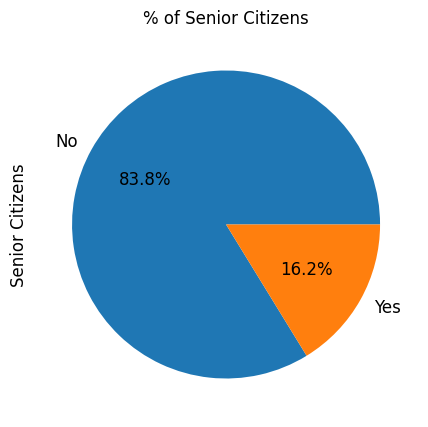

In [16]:
import matplotlib.ticker as mtick
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

Let us look at the customers by partners and dependents

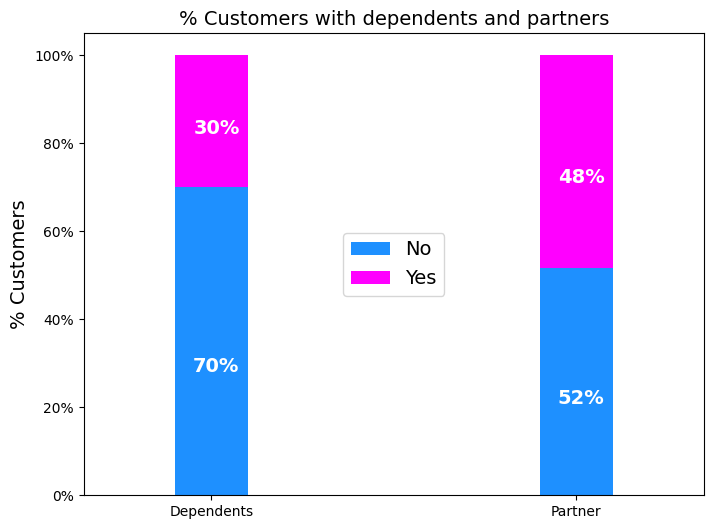

In [21]:
df2 = pd.melt(data, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(data)
colors = ['dodgerblue','fuchsia']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)


Let us look at something more interesting, the percentage of customers who have both partners and dependents

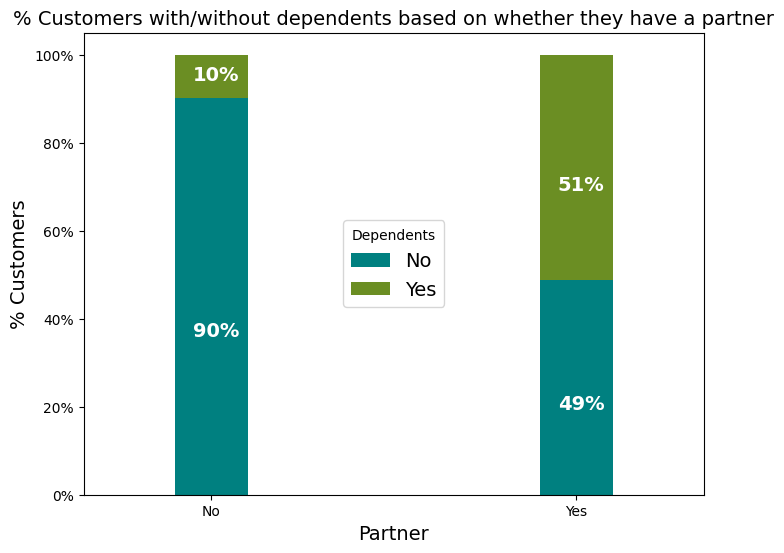

In [24]:
colors = ['teal','olivedrab']
partner_dependents = data.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Now to look at the distribution of various services among customers

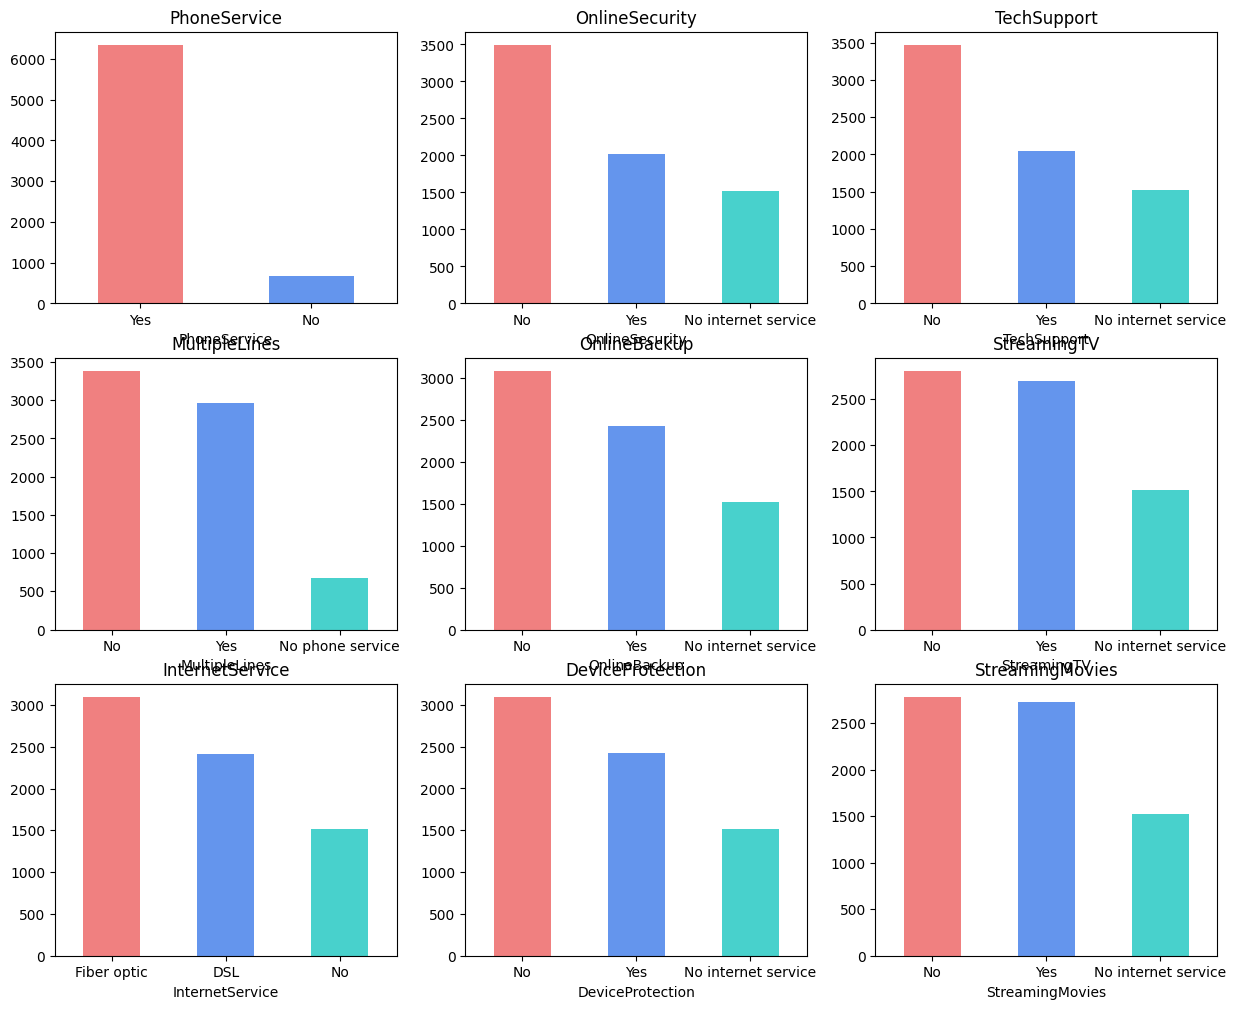

In [27]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
        
colors = ['lightcoral','cornflowerblue','mediumturquoise']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i,0],color=colors,rot = 0)
        
    elif i >=3 and i < 6:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],color=colors,rot = 0)
        
    elif i < 9:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],color=colors,rot = 0)
    ax.set_title(item)

Now we proceed to prediction, first we train the data.


In [43]:
feature_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract', 'PaperlessBilling','PaymentMethod','TotalCharges',
 'activity','tenure','MonthlyCharges']

label_cols = 'Churn'

features , label = data[feature_cols], data[label_cols]


In [44]:
np.unique(label,return_counts=True)

(array(['No', 'Yes'], dtype=object), array([5174, 1869], dtype=int64))

In [45]:
from imblearn.under_sampling import AllKNN
features, label = AllKNN(n_neighbors=7).fit_resample(features, label)

ValueError: could not convert string to float: 'Female'